# DL lab

Загрузим необходимые библиотеки и определим константы, конфигурирующие модели и обучение.

In [1]:
import albumentations
import numpy as np
import pandas as pd
import os
import glob
import random
from tqdm import tqdm

# PyTorch Model
import torch
from torch import nn
from torch.nn import functional as F

# Dataset Loading
from PIL import Image
from PIL import ImageFile

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Model Training
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configurations for the files
DIR = "samples/"
BATCH_SIZE = 16
IMG_HEIGHT = 75
IMG_WIDTH = 300
EPOCHS = 200
NUM_WORKERS = 0
DEVICE = "cpu"
print(f"Using device: {DEVICE}")

Using device: cpu


# Анализ избражения
Пробежимся по нескольким изобрежениям и сравним их с метками на предмет адекватной разметки. 

In [3]:
paths = []
labels = []
for image in os.listdir(DIR):
    paths.append(os.path.join(DIR, image))
    labels.append(image.split(".")[0])

df = pd.DataFrame({
    "paths": paths,
    "labels": labels
})

df.head()

,paths,labels
0,samples/p5g5m.png,p5g5m
1,samples/e72cd.png,e72cd
2,samples/pgmn2.png,pgmn2
3,samples/6cm6m.png,6cm6m
4,samples/68wfd.png,68wfd


In [4]:
def show_random_images(df, column_name):
    f = plt.figure(figsize=(10,10))
    i=1
    for i in range(16):
        i += 1
        ax = f.add_subplot(4,4,i)
        sample = random.choice(df[column_name])
        image = mpimg.imread(sample)
        ax.set_title(sample.split("/")[-1])
        plt.imshow(image)


Каждая капча состоит из 5 символов, иногда изображение искажено черточками и размазанными буквами.

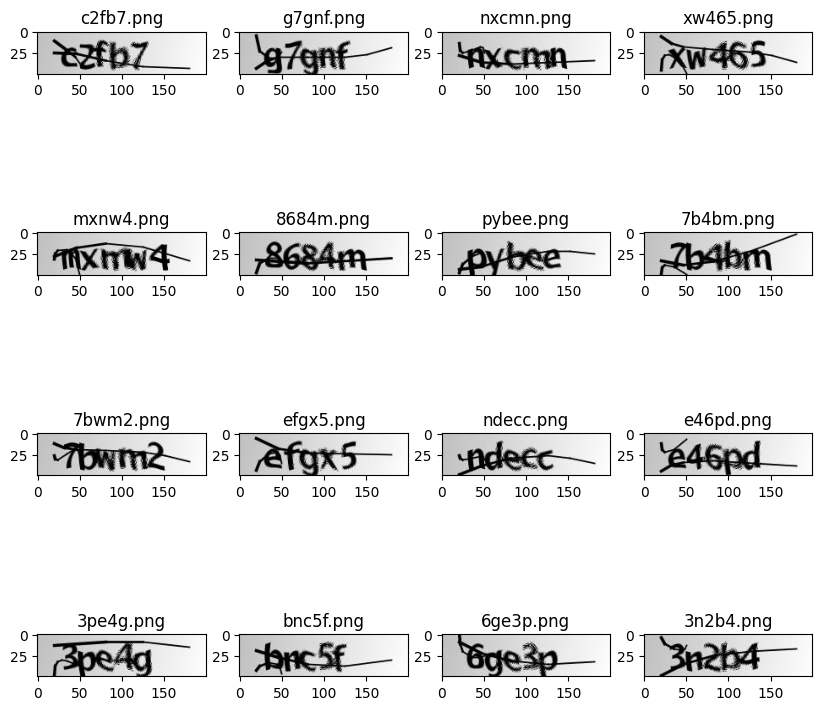

In [5]:
show_random_images(df, "paths")

# Model Definition

Определим модель. Будем использовать следующую архитектуру: исполользуем два слоя CNN для выделения информации о символах, а затем используем GRU, чтобы закодировать последовательность символов. Мы используем CTCLoss в качестве loss функции.

In [6]:
def get_loss_function(x, bs, targets):
    log_softmax_values = F.log_softmax(x, 2)

    input_lengths = torch.full(
        size=(bs,), fill_value=log_softmax_values.size(0), dtype=torch.int32
    )

    target_lengths = torch.full(
        size=(bs,), fill_value=targets.size(1), dtype=torch.int32
    )

    return nn.CTCLoss(blank=0)(log_softmax_values, targets, input_lengths, target_lengths)

In [7]:
class MyCaptchaModel(nn.Module):
    def __init__(self, num_chars):
        super(MyCaptchaModel, self).__init__()
        
        # CNN Layer
        self.conv1 = nn.Conv2d(3, 128, kernel_size=(3,3), padding=(1,1))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.conv2 = nn.Conv2d(128, 64, kernel_size=(3,3), padding=(1,1))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))
        
        # RNN Layer Preprocess
        self.linear1 = nn.Linear(1152, 64)
        self.drop1 = nn.Dropout(0.2)
        
        # Здесь мы выбрали GRU вместо LSTM, поскольку GRU немного быстрее
        self.gru = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.25, batch_first=True)
        self.output = nn.Linear(64, num_chars+1)
        
        
    def forward(self, images, targets=None):  
        bs, channel, height, width = images.size()
        
        x = F.relu(self.conv1(images))
        x = self.maxpool1(x)

        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)

        x = x.permute(0, 3, 1, 2)
        x = x.view(bs, x.size(1), -1)

        x = self.linear1(x)
        x = self.drop1(x)

        x, _ = self.gru(x)
        x = self.output(x)
        x = x.permute(1, 0, 2)

        if targets is not None:
            loss = get_loss_function(x, bs, targets)
            return x, loss
        
        return x, None

Опишем функции для обучения и валидации, которые будут пропускать через модель данные и возвращать loss.

In [8]:
def train_function(model, data_loader, optimizer):
    model.train()
    fin_loss = 0
    for data in data_loader:
        for k, v in data.items():
            data[k] = v.to(DEVICE)
        
        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        optimizer.step()
        fin_loss += loss.item()

    return fin_loss / len(data_loader)


def eval_function(model, data_loader):
    model.eval()
    fin_loss = 0
    fin_preds = []
    with torch.no_grad(): 
        tk = tqdm(data_loader, total=len(data_loader))
        for data in tk:
            for k, v in data.items():
                data[k] = v.to(DEVICE)
            
            batch_preds, loss = model(**data)
            fin_loss += loss.item()
            fin_preds.append(batch_preds)

        return fin_preds, fin_loss / len(data_loader)

# Label encoding

Теперь закодируем имя каждой капчи с помощью Label Encoder, соответствующий вектор и будет таргетным значением для модели.

In [9]:
def encode_targets():
  # Load images from files
  image_files = glob.glob(os.path.join(DIR, "*.jpg"))
  image_files_png = glob.glob(os.path.join(DIR, "*.png"))
  image_files.extend(image_files_png)
  targets_orig = [x.split("/")[-1].split(".")[0] for x in image_files]
  targets = [[c for c in x] for x in targets_orig]
  targets_flat = [c for clist in targets for c in clist] # squeeze

  # Encode images
  lbl_enc = LabelEncoder()
  lbl_enc.fit(targets_flat)

  targets_enc = [lbl_enc.transform(x) for x in targets]
  targets_enc = np.array(targets_enc) + 1 # transform to np and remove 0 index

  return image_files, targets_enc, targets_orig, lbl_enc

In [10]:
# Train-test split
image_files, targets_enc, targets_orig, lbl_enc = encode_targets()

(train_imgs, test_imgs, train_targets, test_targets, _, test_orig_targets) = train_test_split(
    image_files, targets_enc, targets_orig, test_size=0.1, random_state=0)

## Datset Classifier

Мы определим класс, который описывает пайплайн загрузки данных для модели, которые мы будет передавать в DataLoader из torch.

In [11]:
ImageFile.LoadTruncatedImages = True

class DatasetClassifier:
    def __init__(self, image_paths, targets, resize=None):
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.aug = albumentations.Compose(
            [
             albumentations.Normalize(always_apply=True)
            ]
            )
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):
        image = Image.open(self.image_paths[item]).convert("RGB")  # TODO: replace with grayscale
        target = self.targets[item]
        
        if self.resize is not None:
            image = image.resize((self.resize[1], self.resize[0]), resample=Image.BILINEAR)
        
        image = np.array(image)
        augmented = self.aug(image=image)
        image = augmented["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        return {
            "images": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(target, dtype=torch.long)
        }

In [12]:
# Загрузим данные для теста и трейна в DataLoader, используя наш класс
train_dataset = DatasetClassifier(
    image_paths=train_imgs, targets=train_targets, resize=(IMG_HEIGHT, IMG_WIDTH)
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)

test_dataset = DatasetClassifier(
    image_paths=test_imgs, targets=test_targets, resize=(IMG_HEIGHT, IMG_WIDTH)
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

In [13]:
for data in train_loader:
    print(data['targets'])

/var/folders/46/9pmddt197tg1cz85qrsc593w0000gn/T/ipykernel_2984/1854501779.py:22: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  image = image.resize((self.resize[1], self.resize[0]), resample=Image.BILINEAR)


tensor([[10, 11, 12, 19, 18],
        [15, 15, 15,  4,  6],
        [13, 11, 13, 17,  3],
        [11,  3,  5, 19, 17],
        [13, 17, 15, 14,  5],
        [ 5,  4, 15, 14, 17],
        [ 1,  2,  4,  5, 13],
        [15,  8,  3,  4, 10],
        [ 9,  7, 15,  7,  9],
        [ 5,  6, 10, 11, 19],
        [ 4, 18,  6, 18,  4],
        [19, 10, 10,  2, 13],
        [ 8, 13, 10,  3, 14],
        [17,  3, 15, 12, 18],
        [ 6, 17, 15,  6,  3],
        [10,  5, 12,  9, 15]])
tensor([[ 2,  3, 16,  9, 15],
        [15, 12,  9, 17, 19],
        [ 6,  6,  2,  7,  6],
        [19, 17,  5,  5,  6],
        [17, 19,  9,  1,  4],
        [ 5,  8, 15, 15, 14],
        [19,  3, 13,  2,  8],
        [ 3, 17,  6,  5, 13],
        [10,  6,  9,  4, 18],
        [18,  8, 11, 14,  5],
        [16, 16, 18,  6,  6],
        [ 6,  5,  2,  3, 19],
        [ 6,  4, 16, 12, 17],
        [15, 15,  5, 17,  5],
        [ 4, 11, 18, 16, 16],
        [ 6,  7, 11, 11,  9]])
tensor([[10, 19, 16,  6, 15],
        

tensor([[18, 15, 15,  9,  2],
        [14, 14, 19,  4, 15],
        [10, 11,  6, 12,  7],
        [18, 18, 15, 11, 19],
        [14,  7, 14,  3, 18],
        [15, 18, 15,  3, 12],
        [ 8,  3, 15, 10,  8],
        [16, 13,  1, 19, 18],
        [15,  2, 12, 12, 15],
        [14,  9,  7, 17,  1],
        [10,  8, 15, 19,  2],
        [ 5, 14, 11, 13, 11],
        [15, 19,  8,  9, 18],
        [ 4,  8, 13,  7, 12],
        [12,  7,  4,  7, 18],
        [ 4, 16,  7, 12, 14]])
tensor([[ 2, 11,  8, 15, 15],
        [11,  9,  5, 16, 14],
        [14, 10, 10, 13,  8],
        [18,  4, 12,  4,  3],
        [13, 14,  1,  9,  1],
        [19,  4,  2,  9,  1],
        [16, 19, 11, 12,  8],
        [ 4,  4, 17,  4,  9],
        [16, 17, 15,  4, 11],
        [15, 12, 15, 10, 17],
        [ 1,  3,  4, 19,  4],
        [15,  8, 14, 18,  6],
        [ 5, 18, 18, 10, 18],
        [ 8,  5, 12,  1, 16],
        [ 9,  5,  6,  3,  4],
        [ 4, 16,  2, 14, 14]])
tensor([[14, 17,  4, 16,  1],
        

tensor([[18,  2,  7, 12, 15],
        [12, 12, 15, 18, 15],
        [ 2, 18,  2,  1,  4],
        [18, 18, 17,  3,  3],
        [13,  4,  4,  8,  3],
        [13,  1,  3,  6, 17],
        [ 1, 13, 19,  8,  5],
        [ 9,  1, 19, 15,  7],
        [ 5,  2, 16, 18, 11],
        [15, 10, 14, 11,  6],
        [ 2,  6, 10,  4,  1],
        [12,  3, 12, 15,  1],
        [ 9, 16, 11,  5,  2],
        [18, 13,  9, 18, 19],
        [ 1,  8, 13,  3,  7],
        [13, 15,  1, 18, 19]])
tensor([[ 3,  6,  3,  2, 16],
        [11, 12, 11,  5,  1],
        [15,  5, 15, 15,  1],
        [12,  9,  5, 18,  8],
        [ 3,  6,  7, 15, 18],
        [13, 15,  8, 15,  3],
        [ 4,  2, 17, 16,  2],
        [ 6, 14,  7, 16, 18],
        [15,  6, 11, 15, 15],
        [15, 10,  4, 17, 13],
        [16,  1, 14,  5, 15],
        [ 7, 15, 16,  1,  1],
        [16, 14, 13,  4,  4],
        [ 5, 10, 10,  1, 19],
        [16, 19,  8, 11, 11],
        [ 2, 15, 19,  3,  4]])
tensor([[13, 15,  1, 10,  2],
        

tensor([[ 4,  8, 15, 10,  6],
        [ 9,  7,  5, 14, 10],
        [ 1, 16,  1, 19,  7],
        [ 5, 14, 19, 13,  8],
        [ 5, 10, 14, 18,  6],
        [ 5, 13,  3,  4, 17],
        [14, 14, 12, 14,  5],
        [14,  1,  1, 11,  2],
        [ 3, 17,  5, 14, 17],
        [19, 17,  7, 19,  4],
        [ 9,  3,  4,  1,  6],
        [13, 16,  1,  1, 18],
        [ 7,  8,  6,  2,  4],
        [12,  1,  1,  8, 15],
        [10,  7, 18,  9, 15],
        [15, 19,  4, 10, 16]])
tensor([[15,  6, 14, 11,  8],
        [17, 18, 19,  3, 15],
        [ 2, 15, 12, 10, 15],
        [17,  7,  8, 15, 18],
        [ 7, 10,  1, 15, 10],
        [17,  4,  1, 12, 15],
        [ 9,  4, 18, 15, 11],
        [ 8, 15,  9,  4, 12],
        [15,  7, 12, 16,  5],
        [19, 19, 13,  4, 13],
        [ 9, 15, 11, 18,  3],
        [14, 14, 13,  1, 14],
        [ 5, 11,  5, 16, 15],
        [ 8,  2, 18, 16, 15],
        [15, 15, 12, 18,  2],
        [ 7, 12, 11, 18, 15]])
tensor([[ 2,  8, 18,  7,  5],
        

Данные разбиты на батчи по BATCH_SIZE каждый и закодированы Label Encoder

# Создадим модель и оптимизатор

Загрузим нашу модель. Мы будем использовать Adam Optimizer с learning rate 3e-4. Также определим функцию для early stopping в случае начала переобучения нашей модели или выхода на плато.

In [14]:
# Load the models
model = MyCaptchaModel(num_chars=len(lbl_enc.classes_))
model.to(DEVICE)

# Create optimizer and callbacks
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.8, patience=5, verbose=True
)

In [15]:
def early_stopping(patience, count, prev_loss, current_loss, threshold):
    if abs(prev_loss - current_loss) < threshold and count >= patience:
        return "stop" 
    elif abs(prev_loss - current_loss) < threshold:
        return "count"
    else:
        return False

## Decoding the Predictions

Определим функцию, которая будет расшифровывать результаты прогноза, используя наш Label Encoder. Выход модели состоит из последовательности вероятности наличия того или иного символа на сегменте изображения. Если модель не уверена в выборе, она прогнозирует 0 и мы заполняем ее прогноз символом  '-'.

In [16]:
def decode_predictions(preds, encoder):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()
    cap_preds = []
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j,:]:
            k = k - 1
            if k == -1:
                temp.append("-")
            else:
                temp.append(encoder.inverse_transform([k])[0])
        tp = "".join(temp)
        cap_preds.append(tp)
    return cap_preds

## Запускаем обучение

Запускаем обучение, вычисляя ошибку на валидации для каждой эпохи для предотвращения переобучения.

In [17]:
patience = 10
count = 0
prev_val_loss = 0
threshold = 0.05
loss = []
val_loss = []

for epoch in range(EPOCHS):
    train_loss = train_function(model, train_loader, optimizer)
    valid_preds, valid_loss = eval_function(model, test_loader)
    valid_cap_preds = []

    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
        valid_cap_preds.extend(current_preds)
        
    print(f"Epoch: {epoch}, train_loss: {train_loss}, valid_loss: {valid_loss}")
    
    
    res = early_stopping(patience, count, prev_val_loss, valid_loss, threshold)
    
    loss.append(train_loss)
    val_loss.append(valid_loss)
    
    if res == "stop":
        print("Early Stopping Implemented.")
        final_epoch = epoch
        break
    elif res == "count" and train_loss < 0.2:
        count += 1
        print(f"Patience at {patience-count}")
    else:
        count = 0
        prev_val_loss = valid_loss

/var/folders/46/9pmddt197tg1cz85qrsc593w0000gn/T/ipykernel_2984/1854501779.py:22: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  image = image.resize((self.resize[1], self.resize[0]), resample=Image.BILINEAR)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.37it/s]


Epoch: 0, train_loss: 13.3505398250017, valid_loss: 4.021968296595982


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.46it/s]


Epoch: 1, train_loss: 3.637845332505273, valid_loss: 3.30866163117545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.38it/s]


Epoch: 2, train_loss: 3.322172805911205, valid_loss: 3.2745646068028043


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.37it/s]


Epoch: 3, train_loss: 3.283233865362699, valid_loss: 3.2684759071895053


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.37it/s]


Epoch: 4, train_loss: 3.271557147385644, valid_loss: 3.269017457962036


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.37it/s]


Epoch: 5, train_loss: 3.2692352748308027, valid_loss: 3.2701726300375804


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.34it/s]


Epoch: 6, train_loss: 3.267110058518707, valid_loss: 3.271389825003488


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.37it/s]


Epoch: 7, train_loss: 3.2664801957177336, valid_loss: 3.272540705544608


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.39it/s]


Epoch: 8, train_loss: 3.26494001951374, valid_loss: 3.27199193409511


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.39it/s]


Epoch: 9, train_loss: 3.2675783399675713, valid_loss: 3.2731621265411377


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.31it/s]


Epoch: 10, train_loss: 3.266389346513592, valid_loss: 3.2712245668683733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.33it/s]


Epoch: 11, train_loss: 3.267294141112781, valid_loss: 3.2725484371185303


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.31it/s]


Epoch: 12, train_loss: 3.265685933535216, valid_loss: 3.2721243585859026


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.33it/s]


Epoch: 13, train_loss: 3.266233127625262, valid_loss: 3.27281277520316


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.37it/s]


Epoch: 14, train_loss: 3.2658509035579493, valid_loss: 3.270779779979161


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.38it/s]


Epoch: 15, train_loss: 3.265425037165157, valid_loss: 3.272116116115025


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.34it/s]


Epoch: 16, train_loss: 3.2659848049038747, valid_loss: 3.2708801882607594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.03it/s]


Epoch: 17, train_loss: 3.265674634057967, valid_loss: 3.2711594785962785


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.25it/s]


Epoch: 18, train_loss: 3.2655978241904835, valid_loss: 3.270463330405099


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.29it/s]


Epoch: 19, train_loss: 3.2655281590633707, valid_loss: 3.272636651992798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.25it/s]


Epoch: 20, train_loss: 3.2655868647528474, valid_loss: 3.270107780184065


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.25it/s]


Epoch: 21, train_loss: 3.264325950966507, valid_loss: 3.26991605758667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.16it/s]


Epoch: 22, train_loss: 3.2647542640811107, valid_loss: 3.2711061409541538


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.20it/s]


Epoch: 23, train_loss: 3.2665738043237904, valid_loss: 3.269890717097691


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.26it/s]


Epoch: 24, train_loss: 3.265823305630293, valid_loss: 3.2683142253330777


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.31it/s]


Epoch: 25, train_loss: 3.2636557758831586, valid_loss: 3.268343210220337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.31it/s]


Epoch: 26, train_loss: 3.2660350252370365, valid_loss: 3.2673941339765276


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.14it/s]


Epoch: 27, train_loss: 3.2656462700640567, valid_loss: 3.2663164819989885


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.20it/s]


Epoch: 28, train_loss: 3.2652803718066608, valid_loss: 3.267249175480434


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.18it/s]


Epoch: 29, train_loss: 3.2629139618795424, valid_loss: 3.264315264565604


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.19it/s]


Epoch: 30, train_loss: 3.2617200632564356, valid_loss: 3.2637361117771695


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.22it/s]


Epoch: 31, train_loss: 3.2635364258875614, valid_loss: 3.265591553279332


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.25it/s]


Epoch: 32, train_loss: 3.262374788034158, valid_loss: 3.26181960105896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.25it/s]


Epoch: 33, train_loss: 3.2604179225984167, valid_loss: 3.2595175334385464


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.28it/s]


Epoch: 34, train_loss: 3.259820590253736, valid_loss: 3.2568415233067105


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.27it/s]


Epoch: 35, train_loss: 3.2547357004196917, valid_loss: 3.2491677488599504


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.27it/s]


Epoch: 36, train_loss: 3.247223002011659, valid_loss: 3.2464267185756137


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.28it/s]


Epoch: 37, train_loss: 3.2369691192126666, valid_loss: 3.2364669186728343


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.21it/s]


Epoch: 38, train_loss: 3.2160224562785666, valid_loss: 3.218390771320888


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.05it/s]


Epoch: 39, train_loss: 3.1870425333742234, valid_loss: 3.1716891697474887


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.19it/s]


Epoch: 40, train_loss: 3.1388245215181443, valid_loss: 3.104903527668544


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.17it/s]


Epoch: 41, train_loss: 3.0659249923268304, valid_loss: 2.993291446140834


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.29it/s]


Epoch: 42, train_loss: 2.9561569143514164, valid_loss: 2.826775755201067


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.31it/s]


Epoch: 43, train_loss: 2.7820710002398883, valid_loss: 2.6079328060150146


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.18it/s]


Epoch: 44, train_loss: 2.539154169989414, valid_loss: 2.3212624277387346


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [17:56<00:00, 153.73s/it]


Epoch: 45, train_loss: 2.2654689960792416, valid_loss: 2.0890959330967496


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.21it/s]


Epoch: 46, train_loss: 1.9620002175940843, valid_loss: 1.7164577756609236


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.20it/s]


Epoch: 47, train_loss: 1.686527093902963, valid_loss: 1.4536545957837785


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.26it/s]


Epoch: 48, train_loss: 1.4597220362209884, valid_loss: 1.2416301284517561


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.16it/s]


Epoch: 49, train_loss: 1.2316664242353597, valid_loss: 1.0010216236114502


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.14it/s]


Epoch: 50, train_loss: 1.05352796785167, valid_loss: 0.8595320667539325


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.25it/s]


Epoch: 51, train_loss: 0.9204794823146257, valid_loss: 0.7489543812615531


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.29it/s]


Epoch: 52, train_loss: 0.8076510185100993, valid_loss: 0.688947890486036


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.08it/s]


Epoch: 53, train_loss: 0.7310786511077255, valid_loss: 0.5780706916536603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.30it/s]


Epoch: 54, train_loss: 0.6389872182588108, valid_loss: 0.5211972892284393


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.26it/s]


Epoch: 55, train_loss: 0.5780610676671638, valid_loss: 0.47896856495312284


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.28it/s]


Epoch: 56, train_loss: 0.5224992549810253, valid_loss: 0.46335981147629873


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.23it/s]


Epoch: 57, train_loss: 0.4815919179408277, valid_loss: 0.4056727077279772


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.24it/s]


Epoch: 58, train_loss: 0.44582129648474395, valid_loss: 0.3855384375367846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.29it/s]


Epoch: 59, train_loss: 0.41009193267978605, valid_loss: 0.33314357910837444


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.21it/s]


Epoch: 60, train_loss: 0.37358621104818873, valid_loss: 0.3489828641925539


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.27it/s]


Epoch: 61, train_loss: 0.350843358235281, valid_loss: 0.31593504335199085


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.21it/s]


Epoch: 62, train_loss: 0.32874099568265386, valid_loss: 0.303127184510231


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.27it/s]


Epoch: 63, train_loss: 0.3004678639232135, valid_loss: 0.28525447632585255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.25it/s]


Epoch: 64, train_loss: 0.2888764047720393, valid_loss: 0.2703487298318318


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.30it/s]


Epoch: 65, train_loss: 0.2659185167218818, valid_loss: 0.24392497965267726


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.26it/s]


Epoch: 66, train_loss: 0.24934415103959257, valid_loss: 0.2502798012324742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.29it/s]


Epoch: 67, train_loss: 0.22734482171105558, valid_loss: 0.21337413787841797


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.91it/s]


Epoch: 68, train_loss: 0.21748767023692367, valid_loss: 0.20928950714213507


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.30it/s]


Epoch: 69, train_loss: 0.20719872708203363, valid_loss: 0.24687924342496054


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.37it/s]


Epoch: 70, train_loss: 0.204449361587157, valid_loss: 0.21823595464229584


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.32it/s]


Epoch: 71, train_loss: 0.19185880119683313, valid_loss: 0.22173149032252176
Patience at 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.28it/s]


Epoch: 72, train_loss: 0.1830983078870617, valid_loss: 0.18640680185386113
Patience at 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.31it/s]


Epoch: 73, train_loss: 0.1733730884849048, valid_loss: 0.21329673273222788
Patience at 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.31it/s]


Epoch: 74, train_loss: 0.1671187113054463, valid_loss: 0.18800118352685655
Patience at 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.33it/s]


Epoch: 75, train_loss: 0.15749440342187881, valid_loss: 0.18565898495061056
Patience at 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.12it/s]


Epoch: 76, train_loss: 0.15295699763982024, valid_loss: 0.1832383551767894
Patience at 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.13it/s]


Epoch: 77, train_loss: 0.14596207623110444, valid_loss: 0.18742498861891882
Patience at 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.12it/s]


Epoch: 78, train_loss: 0.14584533222874657, valid_loss: 0.18276719110352652
Patience at 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.28it/s]


Epoch: 79, train_loss: 0.14443358046109558, valid_loss: 0.1822985080736024
Patience at 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.30it/s]


Epoch: 80, train_loss: 0.14038891064338996, valid_loss: 0.20616240267242705
Patience at 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.25it/s]

Epoch: 81, train_loss: 0.13634015314403128, valid_loss: 0.1729146550808634
Early Stopping Implemented.


In [67]:
torch.save(model.state_dict(), "./model.bin")

# Model Performance

Построим график, показывающий зависимость loss на обучении и валидации от эпохи. 

<AxesSubplot: title={'center': 'Loss During Epoch Training'}, xlabel='Epoch No.', ylabel='Loss Value'>

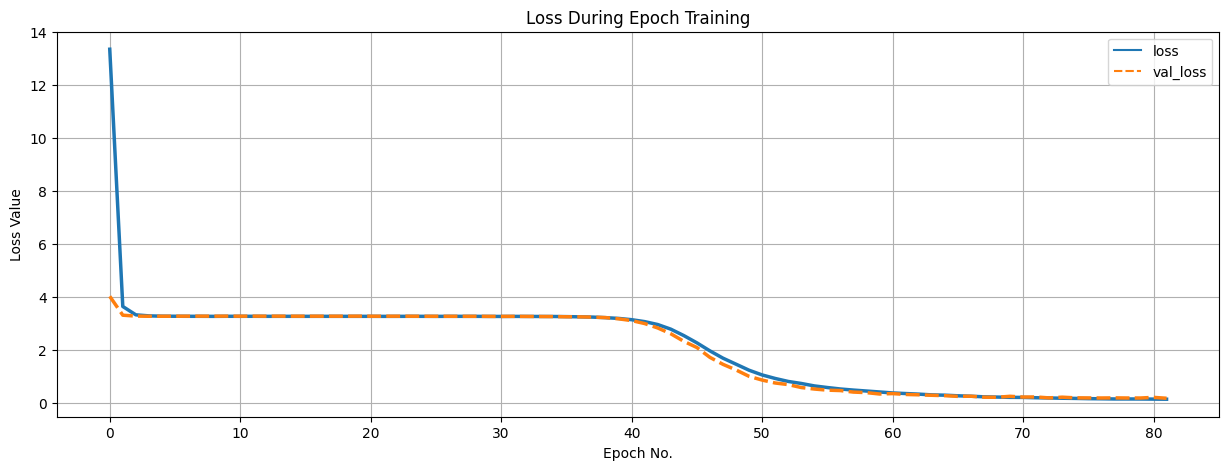

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pytorch = pd.DataFrame({"loss": loss, "val_loss": val_loss})
plt.figure(figsize=(15,5))
plt.grid()
plt.xlabel("Epoch No.")
plt.ylabel("Loss Value")
plt.title("Loss During Epoch Training")
sns.lineplot(data=df_pytorch, palette="tab10", linewidth=2.5)

# Decode Predictions

результаты прогнозирования необходимо перевести в исходный вид 5 значной капчи. Для этого мы будем убирать повторяющиеся символы в соседних сегментах изображения и заменять '-' на пропуски.

In [19]:
def predict_function(model, data_loader):
    model.eval()
    fin_preds = []
    with torch.no_grad(): 
        for data in data_loader:
            for k, v in data.items():
                data[k] = v.to(DEVICE)
            
            batch_preds, _ = model(**data)
            fin_preds.append(batch_preds)

        return fin_preds

In [20]:
def clean_decoded_predictions(unclean_predictions):
    cleaned_predictions = []
    for i in unclean_predictions:
        if i != "-":
            cleaned_predictions.append(i)
            
    cleaned_predictions = "".join(cleaned_predictions)
    
    if len(cleaned_predictions) == 10:
        return cleaned_predictions   
    
    else:
        prev = "-"
        new_cleaned_predictions = []
        for char in cleaned_predictions:
            if char == prev:
                continue
            new_cleaned_predictions.append(char)
            prev = char
        res = "".join(new_cleaned_predictions)
        return res
    
def predict_captcha(model, eval_loader, image_path):
    plt.figure(figsize=(15,5))
    image = mpimg.imread(image_path[0])
    target = image_path[0].split("/")[-1].split(".")[0]
    plt.title(image_path[0].split("/")[-1])
    plt.imshow(image)
    
    valid_preds = predict_function(model, eval_loader)
    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
    
    preds = clean_decoded_predictions(current_preds[0])
    
    success = True if preds == target else False

    return {
        "success": success,
        "prediction": preds,
        "real": target
    }

# Char Error Rate 

Вычислим посимвольную ошибку нашей модели на тестовых данных.

In [21]:
from torchmetrics import CharErrorRate

def caclulate_cer(model, data_loader, lbl_enc):
    valid_preds, valid_loss = eval_function(model, data_loader)
    valid_cap_preds = []

    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
        valid_cap_preds.extend(current_preds)

    clean_preds = [clean_decoded_predictions(x) for x in valid_cap_preds]
    clean_preds


    cer = CharErrorRate()
    return cer(clean_preds, test_orig_targets)

print(caclulate_cer(model, test_loader, lbl_enc))

/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: <0B637046-A38B-3A5C-80C6-E847C27DCCD5> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <BB02660F-1D5B-3388-B48B-486877D726F6> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
  0%|                                                                                                                                                                                           | 0/7 [00:00<?, ?it/s]/var/folders/46/9pmddt197tg1cz85qrsc593w0000gn/T/ipykernel_2984/1854501779.py:22: De

tensor(0.1047)


# Вывод


Мы получили CER  0.1047 на тестовой выборке. Дальнейшее улучшение может быть связано с уменьшением лернингрейта, ослаблением early_stopping и увеличением числа эпох.